In [118]:
import cobra
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from cobra.io import load_json_model

# In this workshop We will use an unpublished version of the <i>C. diff</i> 630 model (iCN900). Please don't distribute!

In [57]:
model_file = 'iCN900_09062018.json'
model = load_json_model(model_file)
model

Name,None
Memory address,0x011cec4a8
Number of metabolites,874
Number of reactions,1216
Objective expression,1.0*BIOMASS - 1.0*BIOMASS_reverse_69053
Compartments,"c, e"


In [3]:
# Load our genome comparison:
filename = 'CD630_vs_112C_genome_comparison.txt'
data = pd.read_csv(filename, sep='\t', skiprows=1) # change this with the name of your C. diff genome
# filter for BBH and high-identity matches
data = data[(data['comp_genome_1_hit']=='bi (<->)') & (data['comp_genome_1_percent_identity']>0.8)]
print len(data) # bbh matches

3422


In [4]:
data[['ref_genome_locus_tag','comp_genome_1_hit','comp_genome_1_percent_identity','comp_genome_1_patric_id']].head()

,ref_genome_locus_tag,comp_genome_1_hit,comp_genome_1_percent_identity,comp_genome_1_patric_id
8,CD0001,bi (<->),1.0,fig|1496.2321.peg.3133
9,CD0002,bi (<->),1.0,fig|1496.2321.peg.3132
10,CD0003,bi (<->),1.0,fig|1496.2321.peg.3131
11,CD0004,bi (<->),1.0,fig|1496.2321.peg.3130
12,CD0005,bi (<->),1.0,fig|1496.2321.peg.3129


In [5]:
model_genes = [g.id for g in model.genes]
print len(model_genes)

900


In [6]:
# genome annotation has changed - need to link PATRIC old locus to new:
locus = pd.read_csv('locus_mapping.csv', index_col=0)
data = pd.merge(data, locus, left_on='ref_genome_locus_tag', right_on='old_locus')
orthologs = data[['locus','comp_genome_1_patric_id']]

In [7]:
orthologs.index=orthologs['locus']
orthologs = orthologs['comp_genome_1_patric_id'].to_dict()

In [8]:
# we will delete all genes from our model that do not have an ortholog in our genome of interest
# get missing genes:
to_delete = set(model_genes)-set(data['locus'].tolist())
print len(to_delete)

34


In [9]:
# don't remove essential genes - note this assumption may be incorrect, e.g. in the case of auxotophy, 
# this should, however allow our draft model to solve
from cobra.flux_analysis import single_gene_deletion
sko= single_gene_deletion(model)
essential_genes = sko[sko['growth']<0.001]
essential_gene_names = [list(g)[0] for g in essential_genes.index.tolist()]

In [10]:
# remove the essential genes from our set of genes to delete
to_curate = list(to_delete&set(essential_gene_names)) # these genes have no ortholog but are predicted to be essential, flag for future curation
to_delete = to_delete-set(essential_gene_names)
print to_curate
print len(to_curate)
print len(to_delete)

[u'CD630_02440']
1
33


In [11]:
# check the functions of the genes missing in our strain of interest:
to_delete = list(to_delete)
for g in to_delete:
    gene = model.genes.get_by_id(g)
    print gene
    for rxn in gene.reactions:
        print '\t', rxn.id, rxn.name, rxn.reaction

CD630_33310
	GF6PTA  f6p_c + gln__L_c --> gam6p_c + glu__L_c
CD630_038901
	6PHBG  cellb6p_c + h2o_c --> g6p_c + glc__D_c
CD630_038903
	6PHBG  cellb6p_c + h2o_c --> g6p_c + glc__D_c
CD630_038902
	6PHBG  cellb6p_c + h2o_c --> g6p_c + glc__D_c
CD630_04300
	COBabc  atp_c + cobalt2_e + h2o_c --> adp_c + cobalt2_c + pi_c
CD630_26660
	GLCADpts  Glc_aD_e + pep_c --> g6p_A_c + pyr_c
CD630_23220'
	TKT1  r5p_c + xu5p__D_c --> g3p_c + s7p_c
CD630_02410
	PSP_L  h2o_c + pser__L_c --> pi_c + ser__L_c
	LTHRK  atp_c + thr__L_c <=> adp_c + thrp_c
CD630_07650
	SBTpts  pep_c + sbt__D_e --> pyr_c + sbt6p_c
CD630_31360
	BGLA1 6-phospho-beta-glucosidase 6pgg_c + h2o_c --> g6p_c + glc__D_c
CD630_07670
	SBTpts  pep_c + sbt__D_e --> pyr_c + sbt6p_c
CD630_28720'
	ALTRH  altrn_c --> 2ddglcn_c + h2o_c
CD630_2179
	FDH  co2_c + h_c + nadh_c --> for_c + nad_c
CD630_26691
	NAt3_1  h_c + na1_e <=> h_e + na1_c
CD630_270801
	SHK3Dr  3dhsk_c + h_c + nadph_c --> nadp_c + skm_c
	SKDH  3dhsk_c + h_c + nadh_c --> nad_c + skm_

# Delete missing orthologs from our new model

In [39]:
from cobra.manipulation.delete import delete_model_genes
model = load_json_model(model_file)
new_model = model.copy()

In [40]:
delete_model_genes(new_model, to_delete)

In [43]:
# show the genes that were removed:
for g in new_model._trimmed_genes:
    print g

CD630_28720'
CD630_04310
CD630_07640
CD630_038903
CD630_038901
CD630_07660
CD630_038902
CD07280
CD630_08160
CD630_13360
CD630_02410
CD630_358802
CD630_270801
CD630_26691
CD630_07680
CD630_0174
CD630_358801
CD630_0176
CD630_23220'
CD630_31370
CD630_0175
CD630_31360
CD630_0769
CD630_33310
CD630_07650
CD630_31470
CD630_13380
CD630_011301
CD630_2179
CD630_09270
CD630_26660
CD630_04300
CD630_07670


In [46]:
# show the reactions that were removed:
for r in new_model._trimmed_reactions:
    print r, r.name

CYTOM: amet_c + csn_c --> 5mcsn_c + ahcys_c + h_c Cytosine 5 methyltransferase
SBTPD: nad_c + sbt6p_c --> f6p_c + h_c + nadh_c 
BGLA1: 6pgg_c + h2o_c --> g6p_c + glc__D_c 6-phospho-beta-glucosidase
TREpts: pep_c + tre_e --> pyr_c + tre6p_c 
SBTpts: pep_c + sbt__D_e --> pyr_c + sbt6p_c 
LTHRK: atp_c + thr__L_c --> adp_c + thrp_c 
ACGApts: acgam_e + pep_c --> acgam6p_c + pyr_c N-Acetyl-D-glucosamine transport via PEP:Pyr PTS
FDH: co2_c + h_c + nadh_c --> for_c + nad_c 


In [47]:
sol = new_model.optimize()

In [48]:
sol.objective_value

0.2102828121195251

In [16]:
# Simulate essential genes in our new model.
# Extra: compare to essential genes in original model

In [17]:
# SOLUTION
res= single_gene_deletion(new_model)

In [31]:
res

,growth,status
ids,,
(CD630_14460),2.102828e-01,optimal
(CD630_07650),2.102828e-01,optimal
(CD630_20850),2.102828e-01,optimal
(CD630_16500),2.102828e-01,optimal
(CD630_27340),2.102828e-01,optimal
(CD630_35580),2.102828e-01,optimal
(CD630_15430),2.102828e-01,optimal
(CD630_21000),2.102828e-01,optimal
(CD630_29900),2.102828e-01,optimal


## Update the GPRs in our model

In [98]:
from cobra import Model
new_model = Model('C. diff 112C')
model = load_json_model(model_file)

In [99]:
from cobra.manipulation.delete import remove_genes

In [100]:
remove_genes(model,to_delete)
sol = model.optimize()
print sol

<Solution 0.210 at 0x1a84cfd0>


In [101]:
model_genes = [g for g in model.genes]
i=0

for g in model_genes:
    if g.id in orthologs.keys():
        ortholog = orthologs[g.id]
        for r in g.reactions:
            r.gene_reaction_rule = r.gene_reaction_rule.replace(g.id,ortholog)
    else:
        print g.id

CD630_02440


In [102]:
for r in model.reactions:
    rxn = r.copy()
    print rxn
    new_model.add_reaction(rxn)
new_model.reactions.BIOMASS.objective_coefficient = 1

TAGabc: atp_c + h2o_c + tagur_e --> adp_c + pi_c + tagur_c
PPATabc: atp_c + h2o_c + ppat_e --> adp_c + pi_c + ppat_c
GLUabc: atp_c + glu__L_e + h2o_c --> adp_c + glu__L_c + pi_c
ASNabc: asn__L_e + atp_c + h2o_c --> adp_c + asn__L_c + pi_c
GLYBabc: atp_c + glyb_e + h2o_c --> adp_c + glyb_c + pi_c
ASPabc: asp__L_e + atp_c + h2o_c --> adp_c + asp__L_c + pi_c
PTRCabc: atp_c + h2o_c + ptrc_e --> adp_c + pi_c + ptrc_c
METDabc: atp_c + h2o_c + met__D_e --> adp_c + met__D_c + pi_c
CHLabc: atp_c + chol_e + h2o_c --> adp_c + chol_c + pi_c
NAabc: atp_c + h2o_c + na1_e --> adp_c + na1_c + pi_c
GLNabc: atp_c + gln__L_e + h2o_c --> adp_c + gln__L_c + pi_c
PIabc: atp_c + h2o_c + pi_e --> adp_c + 2 pi_c
ARGabc: arg__L_e + atp_c + h2o_c --> adp_c + arg__L_c + pi_c
HISabc: atp_c + h2o_c + his__L_e --> adp_c + his__L_c + pi_c
TYRabc: atp_c + h2o_c + tyr__L_e --> adp_c + pi_c + tyr__L_c
ZNabc: atp_c + h2o_c + zn2_c --> adp_c + pi_c + zn2_e
G3Pabc: atp_c + g3p_e + h2o_c --> adp_c + pi_c + sng3p_c
FE2abc: a

ADCL: 4adcho_c --> 4abz_c + pyr_c
DACL: abg4_c + h2o_c + h_c <=> 4abz_c + glu__D_c
DHPS2_1: 4abz_c + 6hmhptpp_c --> dhpt_c + ppi_c
GTPCI_2: gtp_c + h2o_c --> ahdt_c + for_c
DHNPA2r: dhnpt_c --> 6hmhpt_c + gcald_c
PMANM: man6p_c --> man1p_c
FRUK: atp_c + f1p_c --> adp_c + fdp_c
r0191: f6p_c + utp_c --> fdp_c + udp_c
MAN1PT2: gdp_c + man1p_c --> gdpmann_c + pi_c
A6PAG: atp_c + gal_c --> adp_c + dgal6p_c
AM6PT: atp_c + man_c --> adp_c + man6p_c
FBP: fdp_c + h2o_c --> f6p_c + pi_c
TALA: g3p_c + s7p_c --> e4p_c + f6p_c
ABFPT: atp_c + fru_c --> adp_c + f6p_c
FBA: dhap_c + g3p_c <=> fdp_c
A6PAG2: atp_c + gal_bD_c --> adp_c + dgal6p_c
FCLPA: fc1p_c <=> dhap_c + lald__L_c
ID6P: f6p_c + itp_c --> fdp_c + idp_c
FBA3: s17bp_c <=> dhap_c + e4p_c
S7AP: atp_c + s7p_c --> adp_c + s17bp_c
DGAK: Glc_aD_c --> fru_c
MAN6PI: man6p_c <=> f6p_c
M1PD: mnl1p_c + nad_c --> f6p_c + h_c + nadh_c
SBTD_D2: nad_c + sbt__D_c <=> fru_c + h_c + nadh_c
CD6P: ctp_c + f6p_c --> cdp_c + fdp_c
UH1U: gal1p_c + utp_c --> ppi_

CELLBpts: cellb_e + pep_c --> cellb6p_c + pyr_c
SUCpts: pep_c + sucr_e --> pyr_c + suc6p_c
MNLpts: mnl_e + pep_c --> mnl1p_c + pyr_c
DACHpts: dachi_e + pep_c --> chtbs6p_c + h_c + pyr_c
FRUpts2: fru_e + pep_c --> f1p_c + pyr_c
TGTpts: pep_c + tgt_e --> pyr_c + tag6p__D_c
GLCpts: glc__D_e + pep_c --> g6p_c + pyr_c
FUCpts: fuc_e + pep_c --> fc1p_c + pyr_c
MOHMT: 3mob_c + h2o_c + mlthf_c --> 2dhp_c + thf_c
2DHPFALDL: 2dhp_c <=> 3mob_c + fald_c
PPCDC: 4ppcys_c --> co2_c + pan4p_c
GCOADH: fad_c + gcoa_c --> fadh2_c + gccoa_c
PBAL: ala_B_c + atp_c + pant__R_c --> amp_c + h_c + pnto__R_c + ppi_c
PPNCL: 4ppan_c + atp_c + cys__L_c --> 4ppcys_c + amp_c + ppi_c
PNTK: atp_c + pnto__R_c --> 4ppan_c + adp_c
ACPPD: h2o_c + hacp_c --> aacp_c + pan4p_c
PNCDC: ptcys_c <=> co2_c + ptth_c
HACPS: aacp_c + coa_c --> hacp_c + pap_c
DPCOAK: atp_c + dpcoa_c --> adp_c + coa_c
PPNCL2: 4ppan_c + ctp_c + cys__L_c --> 4ppcys_c + cmp_c + ppi_c
APNPT: atp_c + ptth_c --> adp_c + pan4p_c
ACLS: pyr_c <=> alac__S_c + co2

DHPM2: 56dthm_c + h2o_c --> 3uib_c
NDPK4: atp_c + dtdp_c --> adp_c + dttp_c
CYTDK2: cytd_c + gtp_c --> cmp_c + gdp_c
NDPK7: atp_c + dcdp_c --> adp_c + dctp_c
TMDS3: dump_c + h_c + mlthf_c + nadph_c --> dtmp_c + nadp_c + thf_c
URIK2: gtp_c + uri_c --> gdp_c + ump_c
PYNP1: cytd_c + pi_c <=> csn_c + r1p_c
NDPK3: atp_c + cdp_c --> adp_c + ctp_c
DURIPP: duri_c + pi_c --> 2dr1p_c + ura_c
DHORTS: cbasp_c --> dhor__S_c + h2o_c
NTPP4: ctp_c + h2o_c --> cmp_c + pi_c
DTTUP: dttp_c + uri_c --> dtdp_c + ump_c
DCYTD: dcyt_c + h2o_c --> duri_c + nh4_c
ITCY: cytd_c + itp_c --> cmp_c + idp_c
NDP7: h2o_c + udp_c --> pi_c + ump_c
NDPK2: atp_c + udp_c --> adp_c + utp_c
NTD3: dcmp_c + h2o_c <=> dcyt_c + pi_c
DUTPDP: dutp_c + h2o_c --> dump_c + ppi_c
UPPN: cala_c + h2o_c --> ala_B_c + co2_c + nh4_c
CPS: atp_c + h_c + hco3_c + nh4_c --> adp_c + cbp_c + pi_c
DTMPK: atp_c + dtmp_c --> adp_c + dtdp_c
CDPPH: cdp_c + h2o_c --> cmp_c + pi_c
URIK3: itp_c + uri_c --> idp_c + ump_c
UTCY: cytd_c + utp_c --> cmp_c + ud

VALTA: akg_c + val__L_c --> 3mob_c + glu__L_c
IPPMIb: 2ippm_c + h2o_c --> 3c2hmp_c
DHAD2: 23dhmp_c --> 3mop_c + h2o_c
VPAMTr: pyr_c + val__L_c --> 3mob_c + ala__L_c
MB2CFO: fad_c + m2bcoa_c --> 2mb2coa_c + fadh2_c
ACHBS: 2obut_c + pyr_c --> 2ahbut_c + co2_c
KARA2: 2ahbut_c + h_c + nadph_c --> 23dhmp_c + nadp_c
MACCOAT: 2maacoa_c + coa_c --> accoa_c + ppcoa_c
OMCDC: 3c4mop_c --> 4mop_c + co2_c
IBHH: 2mbald_c + h_c + nadh_c <=> ibtol_c + nad_c
MMSAD1: 2mop_c + coa_c + nad_c <=> co2_c + h_c + nadh_c + ppcoa_c
PCFPT: 2obut_c + coa_c <=> for_c + ppcoa_c
CNOR: copre6_c + h_c + nadh_c --> codhpre6_c + nad_c
SHCHD2: dscl_c + nad_c --> h_c + nadh_c + scl_c
CYRDAAT: atp_c + co1dam_c --> adcobdam_c + pppi_c
ALMPC: amet_c + pc1_c --> ahcys_c + dscl_c
ACBIPGT: acap_c + gtp_c --> agdpcbi_c + ppi_c
NNDMBRT: dmbzid_c + nicrnt_c --> 5prdmbz_c + h_c + nac_c
CPPPGO2: amet_c + cpppg3_c --> co2_c + dad_5_c + met__L_c + pppg9_c
BTS4E: amet_c + dtbt_c + ssc_c --> btn_c + dad_5_c + met__L_c + unsc_c
UPP3S: hm

GLYP: atp_c + glyc_c --> adp_c + sng3p_c
PCHD: hex1decg3p_c + palmcoa_c --> coa_c + dhex12decg3p_c
MCHD: myrstcoa_c + tet1decg3p_c --> coa_c + dtet12radecg3p_c
SRCHD: oct1decg3p_c + srcoa_c --> coa_c + di12octdecg3p_c
DHPH: adp_c + dhex12decg3p_c <=> atp_c + dgdi12hexdec_c
DTPH: adp_c + dtet12radecg3p_c <=> atp_c + dgdi12tetdec_c
DOPH: adp_c + di12octdecg3p_c <=> atp_c + dgdi12octdec_c
UDGMS: dgdi12hexdec_c + udpg_c <=> mglucsyldpalmgl_c + udp_c
UDSDM: dgdi12tetdec_c + udpg_c <=> mglucsyldmygl_c + udp_c
UDMGS: dgdi12octdec_c + udpg_c <=> mglucsyldstgl_c + udp_c
UDMDP: mglucsyldpalmgl_c + udpg_c <=> dgludpalmgl_c + udp_c
UMGDS: mglucsyldmygl_c + udpg_c <=> dgludmygl_c + udp_c
UMGSDS: mglucsyldstgl_c + udpg_c <=> digludstgl_c + udp_c
ALAALAP: alaala_c + atp_c + ugmd_c --> adp_c + pi_c + udpamagdapaa_c
PGHDGM: dgludpalmgl_c + phosglcdihexdec_c <=> gpgl_c + mglucsyldpalmgl_c
PGMHDGM: dgludmygl_c + phosglcditetdec_c <=> gpgl_c + mglucsyldmygl_c
PGOHDGM: digludstgl_c + phosglcdioctdec_c <=> 

In [103]:
print new_model.reactions.BIOMASS.objective_coefficient

sol = new_model.optimize()
print sol
print len(new_model.reactions)
ex_rxns = [r for r in model.reactions if r.id.startswith('EX') and r.lower_bound<0]
print ex_rxns

1.0
<Solution 0.210 at 0x1974d6a0>
1208
[<Reaction EX_phe__L_e at 0x1bd03fd0>, <Reaction EX_thm_e at 0x1bd18080>, <Reaction EX_leu__L_e at 0x1bd180f0>, <Reaction EX_k_e at 0x1bd181d0>, <Reaction EX_pydxn_e at 0x1bd18240>, <Reaction EX_gly_e at 0x1bd186a0>, <Reaction EX_gln__L_e at 0x1bd18710>, <Reaction EX_fe2_e at 0x1bd187f0>, <Reaction EX_lys__L_e at 0x1bd18940>, <Reaction EX_cobalt2_e at 0x1bd18a90>, <Reaction EX_ala__L_e at 0x1bd18b70>, <Reaction EX_ca2_e at 0x1bd18be0>, <Reaction EX_uri_e at 0x1bd18d30>, <Reaction EX_dad_2_e at 0x1bd18e80>, <Reaction EX_ins_e at 0x1bd18f60>, <Reaction EX_ribflv_e at 0x1bd18fd0>, <Reaction EX_glc__D_e at 0x1bd731d0>, <Reaction EX_arg__L_e at 0x1bd73240>, <Reaction EX_ile__L_e at 0x1bd73320>, <Reaction EX_mg2_e at 0x1bd73390>, <Reaction EX_dcyt_e at 0x1bd73400>, <Reaction EX_pro__L_e at 0x1bd735c0>, <Reaction EX_pi_e at 0x1bd736a0>, <Reaction EX_tyr__L_e at 0x1bd73710>, <Reaction EX_trp__L_e at 0x1bd73860>, <Reaction EX_ncam_e at 0x1bd73b00>, <React

In [104]:
# save our new model:
cobra.io.save_json_model(new_model,'iCdiff112c_draft.json')

In [105]:
# work with our new model as the model from now on:
model = load_json_model('iCdiff112c_draft.json')
sol = model.optimize()
print sol

<Solution 0.210 at 0x18d20358>


In [106]:
# Check growth capabilities of our model

In [107]:
def set_min_media(model):
    # set all exchange reactions to lower bound of 0: e.g. nothing can enter the cell
    ex_rxns = [r for r in model.reactions if r.id.startswith('EX')]
    for r in ex_rxns:
        r.lower_bound = 0
        
    #define our minimal media exchanges:
    min_media = {
        'EX_glc__D_e':-10,
        'EX_leu__L_e':-1,
        'EX_k_e': -1000,
        'EX_pydxn_e': -1,
        'EX_fe2_e': -1000,
        'EX_cobalt2_e': -1000,
        'EX_ca2_e': -1000,
        'EX_ile__L_e': -1,
        'EX_mg2_e': -1000,
        'EX_pro__L_e': -1,
        'EX_pi_e': -1000,
        'EX_trp__L_e': -1,
        'EX_met__L_e': -1,
        'EX_cys__L_e': -1,
        'EX_btn_e': -1,
        'EX_pnto__R_e': -1,
        'EX_na1_e': -1000,
        'EX_zn2_e': -1000,
        'EX_h_e': -1000,
        'EX_co2_e': -1000,
        'EX_val__L_e': -1,
        'EX_h2o_e': -1000,
        'EX_sel_e': -1000,
        'EX_slnt_e': -1000
    }
    for r in min_media.keys():
        rxn = model.reactions.get_by_id(r)
        rxn.lower_bound = min_media[r]
    return model

In [108]:
new_model = set_min_media(new_model)
sol = new_model.optimize()
print sol

<Solution 0.015 at 0x1672f128>


In [127]:
# SOLUTION
new_model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
sol = new_model.optimize()
print sol
growth = {}
ex_rxns = [r for r in new_model.reactions if r.id.startswith('EX')]

for r in ex_rxns:
    print r
    lb = r.lower_bound
    r.lower_bound = -10
    sol = new_model.optimize()
    print sol
    r.lower_bound = lb
    growth[r.id]=sol.objective_value
growth = pd.Series(growth)

<Solution -0.000 at 0x1a63d0b8>
EX_tre_e: tre_e --> 
<Solution -0.000 at 0x16f9bcc0>
EX_co1dam_e: co1dam_e --> 
<Solution -0.000 at 0x1a63d208>
EX_phe__L_e: phe__L_e --> 
<Solution -0.000 at 0x16f9bf60>
EX_thm_e: thm_e --> 
<Solution -0.000 at 0x1a63d588>
EX_leu__L_e: leu__L_e <=> 
<Solution 0.000 at 0x16f9b908>
EX_dachi_e: dachi_e --> 
<Solution 0.023 at 0x1a63d7f0>
EX_k_e: k_e <=> 
<Solution 0.000 at 0x16f9bcc0>
EX_pydxn_e: pydxn_e <=> 
<Solution 0.000 at 0x1a63d240>
EX_ac_e: ac_e --> 
<Solution 0.004 at 0x12a1c0f0>
EX_cdpg_e: cdpg_e --> 
<Solution 0.000 at 0x11c65978>
EX_etoh_e: etoh_e --> 
<Solution 0.015 at 0x18c36518>
EX_malt_e: malt_e --> 
<Solution 0.015 at 0x1b175b70>
EX_galt_e: galt_e --> 
<Solution 0.015 at 0x1a84ca20>
EX_Glc_aD_e: Glc_aD_e --> 
<Solution 0.015 at 0x155fe048>
EX_glyc_e: glyc_e --> 
<Solution 0.015 at 0x11599390>
EX_mnl_e: mnl_e --> 
<Solution 0.015 at 0x1c8e8080>
EX_d23hb_e: d23hb_e --> 
<Solution 0.000 at 0x1974dac8>
EX_gly_e: gly_e --> 
<Solution 0.019 at 

In [128]:
growth = pd.DataFrame(growth.sort_values())

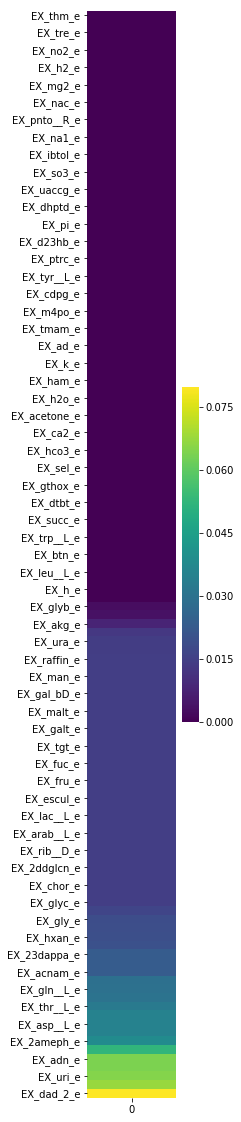

In [135]:
fig, ax = plt.subplots(figsize=(2,20))  
sns.heatmap(growth, fmt="g", cmap='viridis')